In [1]:
!pip install pymavlink

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 102.7 MB/s eta 0:00:00


In [4]:
import os

def read_rlog_file(file_path):
    """Read and analyze the contents of an rlog file"""
    print(f"\nAnalyzing file: {os.path.basename(file_path)}")

    try:
        with open(file_path, 'rb') as f:  # Open in binary mode
            # Read first few lines to examine structure
            print("\nFirst 10 lines of content:")
            count = 0
            for line in f:
                try:
                    # Try to decode as UTF-8 first
                    decoded_line = line.decode('utf-8').strip()
                    print(f"Line {count + 1}: {decoded_line}")
                except UnicodeDecodeError:
                    # If UTF-8 fails, show hex representation
                    print(f"Line {count + 1} (hex): {line.hex()[:100]}...")
                count += 1
                if count >= 10:
                    break

            # Get file size
            f.seek(0, 2)  # Seek to end
            file_size = f.tell()
            print(f"\nTotal file size: {file_size} bytes")

            # Sample from middle of file
            middle_pos = file_size // 2
            f.seek(max(0, middle_pos - 500))  # Go to middle minus 500 bytes
            print("\nSample from middle of file:")
            sample = f.read(1000)  # Read 1000 bytes around middle
            try:
                print(sample.decode('utf-8'))
            except UnicodeDecodeError:
                print(f"Binary data (hex): {sample.hex()[:100]}...")

    except Exception as e:
        print(f"Error reading file: {e}")

# Test with a problematic rlog file
file_path = '/content/sample_data/2024-12-12 06-50-28.rlog'
read_rlog_file(file_path)


Analyzing file: 2024-12-12 06-50-28.rlog

First 10 lines of content:
Line 1 (hex): fd1c0000b40101210000910909006c242b141ac005d098f80000f3ffffff000001000000dd7f3615fd1f0000b50101010000...
Line 2 (hex): 01cafd190000b801013e0000ae47e13d47e1fabf9999e74142e392c200000000e1ffe1ff01e40dfd050000b901012a000001...
Line 3 (hex): d7a33e63affd0d0000c90101840000b90909000a...
Line 4 (hex): 00401f2000000019e991fd150000ca01018800006c242b141ac005d0fe4a7b427217513f64000000e097a5fd160000cb0101...
Line 5 (hex): 09004a6c24bcc80e6fbc29f711bfd04870ba00c9a3b852f15039d24efd120000d901014a00004ef9bd3ebb85333c5c8f7e42...
Line 6 (hex): 0b51230167fd290000dd0101162b002a12000000000000000000000000000000000000000000000000000000000000530200...
Line 7 (hex): 00acfd190000e401013e0000ae47e13d47e1fabf14aee741a42b65c200000000e1ffe1ff01eabefd050000e501012a000001...
Line 8 (hex): d7a33e53defd0d0000f50101840000ad0b09000a...
Line 9 (hex): 00401f2000000019b6befd150000f601018800006b242b141bc005d0c54a7b4256964e3f64000000e09490fd1600

In [6]:
import os
import glob
from pymavlink import mavutil
import json
from datetime import datetime
from collections import defaultdict
import struct

def parse_rlog_binary(file_path):
    """Parse .rlog file as raw binary data."""
    messages = []
    try:
        with open(file_path, 'rb') as f:
            msg_count = 0
            while True:
                # Read header - looking for 0xFD (MAVLink v2) or 0xFE (MAVLink v1)
                byte = f.read(1)
                if not byte:
                    break

                if byte[0] in [0xFD, 0xFE]:  # MAVLink packet markers
                    try:
                        if byte[0] == 0xFD:  # MAVLink v2
                            length = int.from_bytes(f.read(1), 'little')
                            if length > 280:  # Max MAVLink v2 packet size
                                continue

                            # Read the rest of the packet
                            incompat_flags = int.from_bytes(f.read(1), 'little')
                            compat_flags = int.from_bytes(f.read(1), 'little')
                            seq = int.from_bytes(f.read(1), 'little')
                            sysid = int.from_bytes(f.read(1), 'little')
                            compid = int.from_bytes(f.read(1), 'little')
                            msgid = int.from_bytes(f.read(3), 'little')
                            payload = f.read(length)
                            checksum = f.read(2)

                            # Create message data
                            data = {
                                'msgtype': f'MSG_{msgid}',
                                'system_id': sysid,
                                'component_id': compid,
                                'sequence': seq,
                                'payload_length': length,
                                'log_source': 'rlog'
                            }

                            # Try to extract timestamp if present in payload
                            if length >= 8:  # Minimum length for timestamp
                                try:
                                    timestamp = struct.unpack('<Q', payload[:8])[0]
                                    data['timestamp'] = timestamp
                                except:
                                    pass

                            messages.append(data)
                            msg_count += 1

                        else:  # MAVLink v1
                            length = int.from_bytes(f.read(1), 'little')
                            if length > 255:  # Max MAVLink v1 packet size
                                continue

                            # Read the rest of the packet
                            seq = int.from_bytes(f.read(1), 'little')
                            sysid = int.from_bytes(f.read(1), 'little')
                            compid = int.from_bytes(f.read(1), 'little')
                            msgid = int.from_bytes(f.read(1), 'little')
                            payload = f.read(length)
                            checksum = f.read(2)

                            data = {
                                'msgtype': f'MSG_{msgid}',
                                'system_id': sysid,
                                'component_id': compid,
                                'sequence': seq,
                                'payload_length': length,
                                'log_source': 'rlog'
                            }

                            # Try to extract timestamp if present
                            if length >= 8:
                                try:
                                    timestamp = struct.unpack('<Q', payload[:8])[0]
                                    data['timestamp'] = timestamp
                                except:
                                    pass

                            messages.append(data)
                            msg_count += 1

                        if msg_count % 1000 == 0:
                            print(f"Processed {msg_count} messages from rlog...", end='\r')

                    except Exception as e:
                        continue

        print(f"\nCompleted processing rlog: {msg_count} valid messages")
        return messages

    except Exception as e:
        print(f"\nError processing rlog file: {e}")
        return messages

def process_tlog_file(file_path):
    """Process .tlog file using pymavlink."""
    messages = []
    try:
        mlog = mavutil.mavlink_connection(file_path)
        msg_count = 0

        while True:
            try:
                msg = mlog.recv_match(blocking=False)
                if msg is None:
                    break

                if msg.get_type() == 'BAD_DATA':
                    continue

                data = {
                    'msgtype': msg.get_type(),
                    'log_source': 'tlog'
                }

                # Add message fields
                if hasattr(msg, '_fieldnames'):
                    for field in msg._fieldnames:
                        try:
                            value = getattr(msg, field)
                            if isinstance(value, bytes):
                                try:
                                    value = value.decode('utf-8', errors='replace')
                                except:
                                    value = ''.join(format(b, '02x') for b in value)
                            data[field] = value
                        except:
                            continue

                if hasattr(msg, '_timestamp'):
                    data['timestamp'] = msg._timestamp

                messages.append(data)
                msg_count += 1

                if msg_count % 1000 == 0:
                    print(f"Processed {msg_count} messages from tlog...", end='\r')

            except Exception as e:
                continue

        print(f"\nCompleted processing tlog: {msg_count} valid messages")
        return messages

    except Exception as e:
        print(f"\nError processing tlog file: {e}")
        return messages

def merge_log_files(directory_path):
    """Find and merge corresponding .tlog and .rlog files."""
    tlog_files = glob.glob(os.path.join(directory_path, '*.tlog'))
    output_dir = os.path.join(directory_path, 'merged_logs')
    os.makedirs(output_dir, exist_ok=True)

    successful_merges = 0
    partial_merges = []
    failed_merges = []

    for tlog_file in tlog_files:
        base_name = os.path.splitext(tlog_file)[0]
        rlog_file = base_name + '.rlog'

        if not os.path.exists(rlog_file):
            print(f"\nNo matching .rlog file found for {os.path.basename(tlog_file)}")
            failed_merges.append(os.path.basename(tlog_file))
            continue

        print(f"\nProcessing pair: {os.path.basename(tlog_file)}")

        try:
            # Process both files
            tlog_messages = process_tlog_file(tlog_file)
            rlog_messages = parse_rlog_binary(rlog_file)

            if not tlog_messages and not rlog_messages:
                print("No valid messages found in either file")
                failed_merges.append(os.path.basename(tlog_file))
                continue
            elif not tlog_messages or not rlog_messages:
                partial_merges.append(os.path.basename(tlog_file))

            # Combine and sort messages
            merged_messages = tlog_messages + rlog_messages
            merged_messages.sort(key=lambda x: x.get('timestamp', 0))

            # Generate summary
            summary = {
                'total_messages': len(merged_messages),
                'tlog_messages': len(tlog_messages),
                'rlog_messages': len(rlog_messages),
                'message_types': defaultdict(lambda: {'tlog': 0, 'rlog': 0})
            }

            for msg in merged_messages:
                msg_type = msg.get('msgtype', 'unknown')
                source = msg.get('log_source', 'unknown')
                summary['message_types'][msg_type][source] += 1

            summary['message_types'] = dict(summary['message_types'])

            # Save merged data
            output_file = os.path.join(output_dir, f"{os.path.basename(base_name)}_merged.json")
            output_data = {
                'summary': summary,
                'messages': merged_messages
            }

            with open(output_file, 'w') as f:
                json.dump(output_data, f, indent=2, default=str)

            print(f"Successfully created merged file: {output_file}")
            print(f"Summary:")
            print(f"- Total messages: {summary['total_messages']}")
            print(f"- TLOG messages: {summary['tlog_messages']}")
            print(f"- RLOG messages: {summary['rlog_messages']}")

            if os.path.basename(tlog_file) in partial_merges:
                print("Note: This was a partial merge (one file had no valid messages)")
            else:
                successful_merges += 1

        except Exception as e:
            print(f"Error merging files: {e}")
            failed_merges.append(os.path.basename(tlog_file))

    print("\nMerge Process Complete:")
    print(f"Fully successful merges: {successful_merges} file pairs")
    print(f"Partial merges: {len(partial_merges)} file pairs")
    print(f"Failed merges: {len(failed_merges)} file pairs")

    if partial_merges:
        print("\nPartial merge files:")
        for file in partial_merges:
            print(f"- {file}")
    if failed_merges:
        print("\nFailed files:")
        for file in failed_merges:
            print(f"- {file}")
    print(f"\nMerged files can be found in: {output_dir}")

# Directory path
directory_path = '/content/sample_data'

# Process and merge files
print("Starting log file merge process...")
merge_log_files(directory_path)

Starting log file merge process...

Processing pair: 2024-12-13 08-57-50.tlog
Processed 14000 messages from tlog...
Completed processing tlog: 14573 valid messages
Processed 7000 messages from rlog...
Completed processing rlog: 7980 valid messages
Successfully created merged file: /content/sample_data/merged_logs/2024-12-13 08-57-50_merged.json
Summary:
- Total messages: 22553
- TLOG messages: 14573
- RLOG messages: 7980

Processing pair: 2024-12-12 06-50-28.tlog
Processed 260000 messages from tlog...
Completed processing tlog: 260365 valid messages
Processed 255000 messages from rlog...
Completed processing rlog: 255326 valid messages
Successfully created merged file: /content/sample_data/merged_logs/2024-12-12 06-50-28_merged.json
Summary:
- Total messages: 515691
- TLOG messages: 260365
- RLOG messages: 255326

Processing pair: 2024-12-12 07-47-07.tlog
Processed 240000 messages from tlog...
Completed processing tlog: 240660 valid messages

Completed processing rlog: 235600 valid mes

In [13]:
!pip install seaborn
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.4 MB/s eta 0:00:00


Found 16 merged log files

Analyzing: 2024-12-13 10-11-42_merged.json

=== MAVLink Log Analysis Report ===

Message Distribution:
- Total Messages: 1460852
- Unique Message Types: 118

Top 10 Message Types:
- MSG_178: 33552 messages
- AHRS2: 33551 messages
- MSG_226: 33387 messages
- RPM: 33369 messages
- MSG_11020: 33365 messages
- AOA_SSA: 33365 messages
- MSG_11030: 33325 messages
- ESC_TELEMETRY_1_TO_4: 33315 messages
- MSG_74: 33231 messages
- VFR_HUD: 33226 messages

Timing Analysis:
- Duration: 18446744069422000128.00 seconds
- Average Message Rate: 0.00 msgs/sec
- Timestamp Gaps:
  - max_gap: 1873496470028554240.0000 seconds
  - min_gap: 0.0000 seconds
  - mean_gap: 13382081291393.4766 seconds
  - std_gap: 2663194632395422.0000 seconds

Communication Statistics:
- Source Distribution:
  - rlog: 723865 messages
  - tlog: 736987 messages

Error Analysis:
- Total Error/Warning Messages: 0

Analyzing: 2024-12-13 08-15-48_merged.json

=== MAVLink Log Analysis Report ===

Message Dis

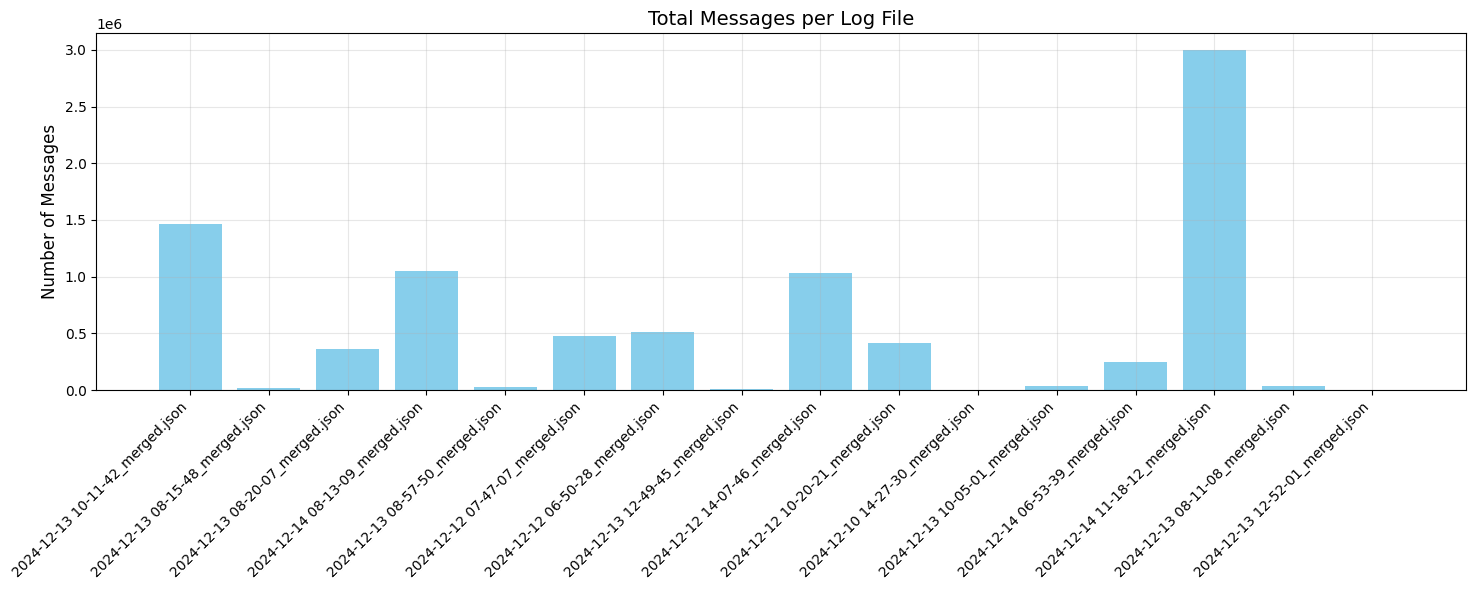

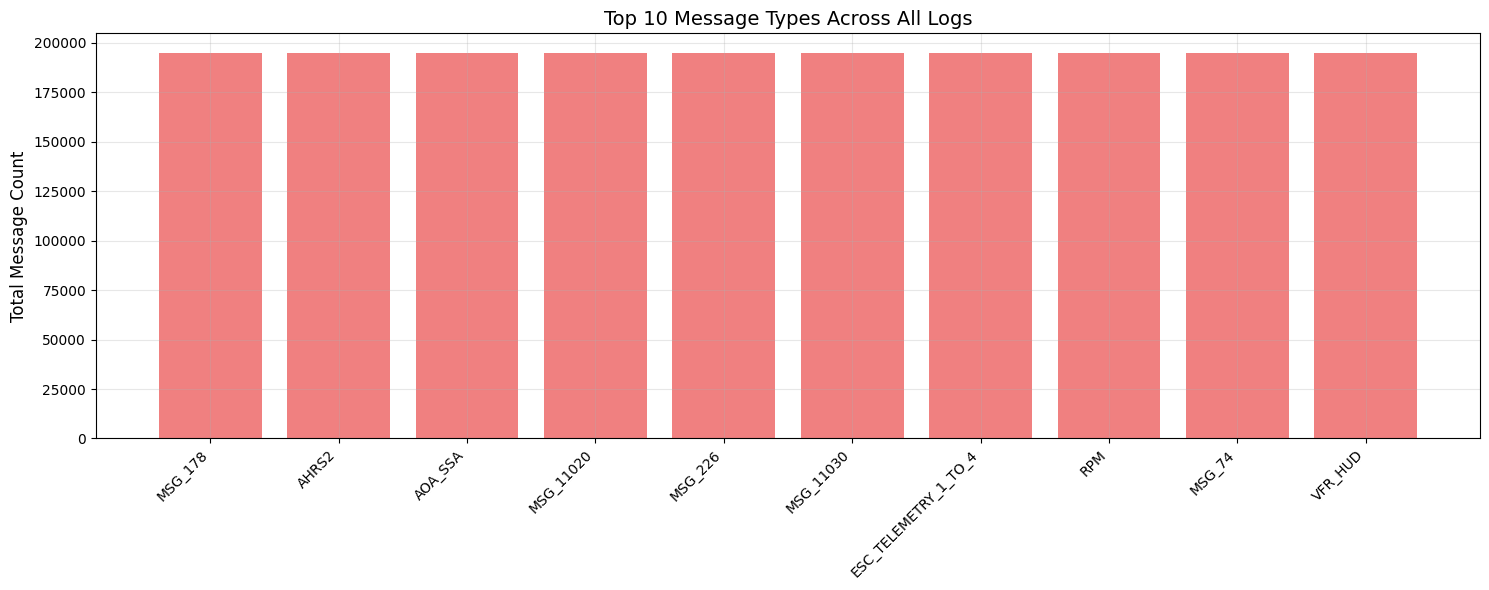

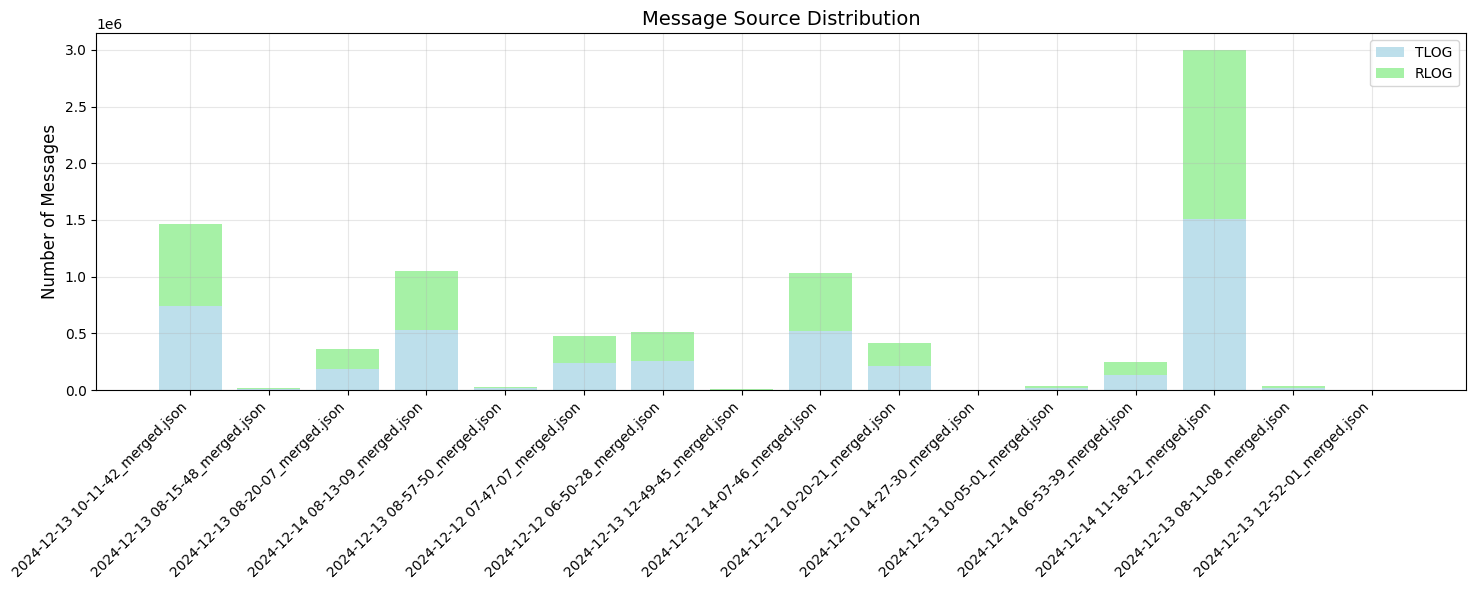

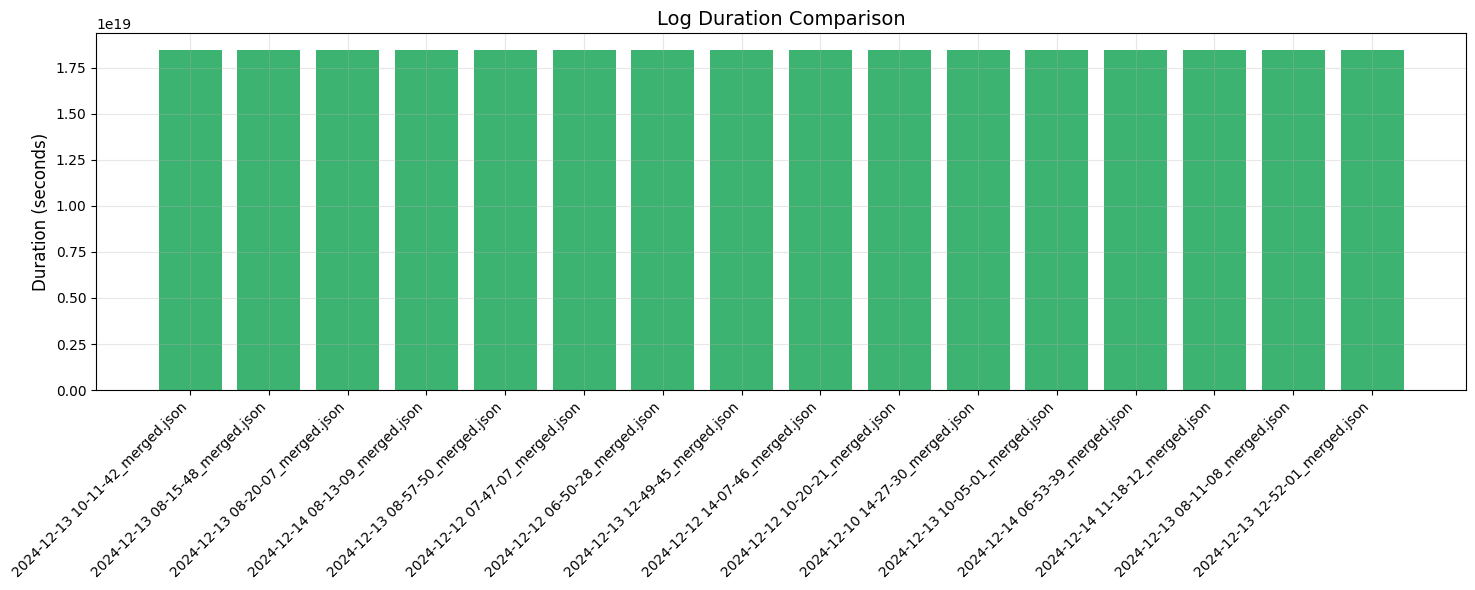

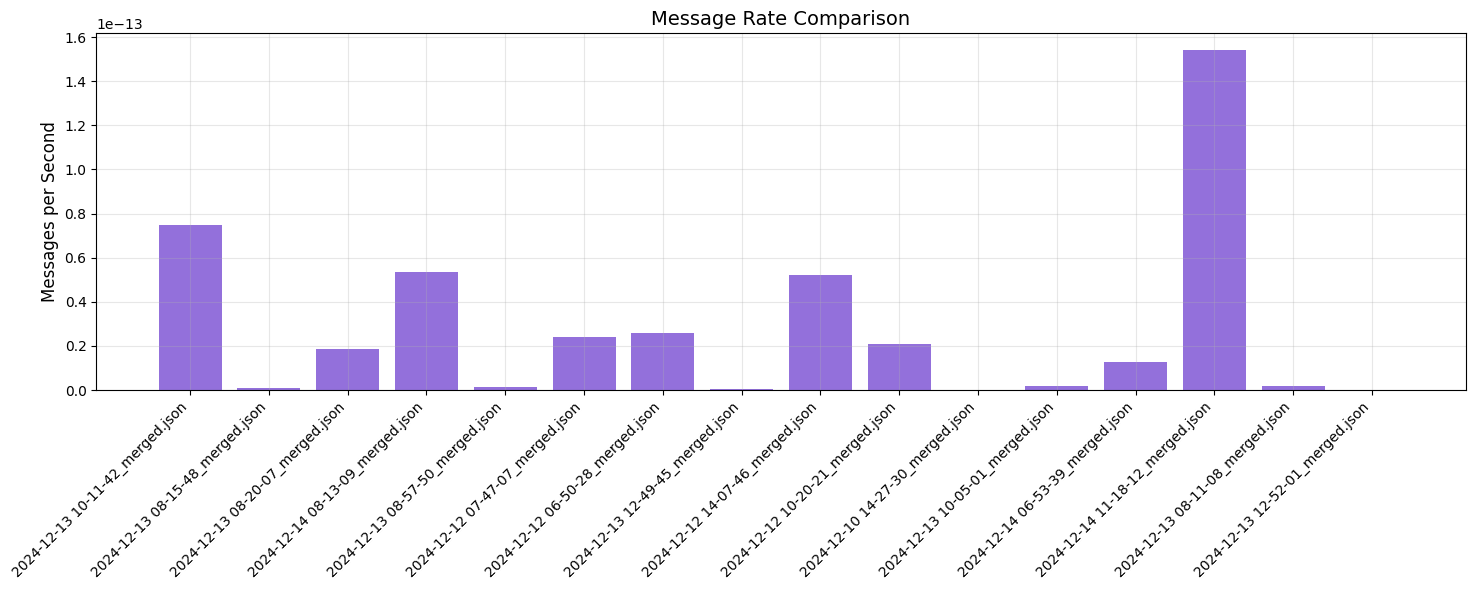


Generating PDF report...
Generating visualizations for PDF...
Building PDF...
PDF report generated: /content/sample_data/merged_logs/mavlink_analysis_report.pdf


In [16]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import glob
import os
from collections import defaultdict
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter, landscape
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.platypus import PageBreak
import io

def analyze_timestamp_gaps(timestamps):
    """Analyze gaps between messages."""
    if not timestamps:
        return {
            'max_gap': 0,
            'min_gap': 0,
            'mean_gap': 0,
            'std_gap': 0
        }

    timestamps = sorted(timestamps)
    gaps = np.diff(timestamps)

    return {
        'max_gap': float(np.max(gaps)) if len(gaps) > 0 else 0,
        'min_gap': float(np.min(gaps)) if len(gaps) > 0 else 0,
        'mean_gap': float(np.mean(gaps)) if len(gaps) > 0 else 0,
        'std_gap': float(np.std(gaps)) if len(gaps) > 0 else 0
    }

def analyze_system_status(heartbeats):
    """Analyze system status from heartbeat messages."""
    status_counts = defaultdict(int)
    mode_counts = defaultdict(int)

    for hb in heartbeats:
        if 'system_status' in hb:
            status_counts[hb['system_status']] += 1
        if 'custom_mode' in hb:
            mode_counts[hb['custom_mode']] += 1

    return {
        'status_distribution': dict(status_counts),
        'mode_distribution': dict(mode_counts),
        'total_heartbeats': len(heartbeats)
    }

def analyze_source_distribution(messages):
    """Analyze message distribution between TLOG and RLOG."""
    sources = defaultdict(int)
    for msg in messages:
        sources[msg.get('log_source', 'unknown')] += 1
    return dict(sources)

def calculate_message_rates(messages):
    """Calculate message rates over time."""
    msg_times = defaultdict(list)

    for msg in messages:
        if 'timestamp' in msg:
            msg_times[msg.get('msgtype', 'unknown')].append(msg['timestamp'])

    rates = {}
    for msg_type, timestamps in msg_times.items():
        if len(timestamps) > 1:
            duration = max(timestamps) - min(timestamps)
            rates[msg_type] = len(timestamps) / duration if duration > 0 else 0

    return rates

def analyze_errors(messages):
    """Analyze error and warning messages."""
    error_msgs = [msg for msg in messages if
                 any(err in msg.get('msgtype', '').upper()
                     for err in ['ERROR', 'FAIL', 'WARN'])]

    error_types = defaultdict(int)
    for msg in error_msgs:
        error_types[msg.get('msgtype', 'unknown')] += 1

    return {
        'total_errors': len(error_msgs),
        'error_types': dict(error_types)
    }

def save_plot_to_bytes(fig):
    """Save a matplotlib figure to bytes buffer."""
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', dpi=300)
    buf.seek(0)
    return buf

def generate_pdf_report(all_analyses, output_path):
    """Generate a PDF report containing all analyses and visualizations."""
    doc = SimpleDocTemplate(
        output_path,
        pagesize=letter,
        rightMargin=72,
        leftMargin=72,
        topMargin=72,
        bottomMargin=72
    )

    # Collect the elements that will make up the PDF
    elements = []

    # Get styles
    styles = getSampleStyleSheet()
    title_style = styles['Heading1']
    heading_style = styles['Heading2']
    normal_style = styles['Normal']

    # Add title
    elements.append(Paragraph("MAVLink Log Analysis Report", title_style))
    elements.append(Spacer(1, 30))

    # Add timestamp
    elements.append(Paragraph(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", normal_style))
    elements.append(Spacer(1, 20))

    # Generate visualizations and add to PDF
    print("Generating visualizations for PDF...")

    try:
        # 1. Message Count Comparison
        plt.figure(figsize=(15, 6))
        file_names = list(all_analyses.keys())
        message_counts = [analysis['message_distribution']['total_messages']
                         for analysis in all_analyses.values()]

        plt.bar(range(len(file_names)), message_counts, color='skyblue')
        plt.xticks(range(len(file_names)), file_names, rotation=45, ha='right')
        plt.title('Total Messages per Log File')
        plt.ylabel('Number of Messages')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Save plot to buffer and add to PDF
        buf = save_plot_to_bytes(plt.gcf())
        elements.append(Paragraph("Message Distribution", heading_style))
        elements.append(Image(buf, width=7*inch, height=3*inch))
        elements.append(Spacer(1, 20))
        plt.close()

        # Add individual file analyses
        elements.append(Paragraph("Individual File Analysis", heading_style))
        elements.append(Spacer(1, 20))

        for idx, (file_name, analysis) in enumerate(all_analyses.items()):
            # Add file header
            elements.append(Paragraph(f"File: {file_name}", heading_style))
            elements.append(Spacer(1, 10))

            # Message Distribution
            md = analysis['message_distribution']
            elements.append(Paragraph("Message Distribution:", heading_style))
            elements.append(Paragraph(f"Total Messages: {md['total_messages']}", normal_style))
            elements.append(Paragraph(f"Unique Message Types: {md['unique_message_types']}", normal_style))
            elements.append(Spacer(1, 10))

            # Top 10 Message Types Table
            elements.append(Paragraph("Top 10 Message Types:", heading_style))
            sorted_msgs = sorted(md['message_types'].items(),
                               key=lambda x: x[1]['count'],
                               reverse=True)[:10]

            table_data = [['Message Type', 'Count']]
            table_data.extend([[msg_type, str(info['count'])] for msg_type, info in sorted_msgs])

            table = Table(table_data, colWidths=[4*inch, 1*inch])
            table.setStyle(TableStyle([
                ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
                ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
                ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                ('FONTSIZE', (0, 0), (-1, 0), 14),
                ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
                ('TEXTCOLOR', (0, 1), (-1, -1), colors.black),
                ('FONTNAME', (0, 1), (-1, -1), 'Helvetica'),
                ('FONTSIZE', (0, 1), (-1, -1), 12),
                ('GRID', (0, 0), (-1, -1), 1, colors.black)
            ]))
            elements.append(table)
            elements.append(Spacer(1, 20))

            # Timing Analysis
            if 'timing_analysis' in analysis and analysis['timing_analysis']:
                ta = analysis['timing_analysis']
                elements.append(Paragraph("Timing Analysis:", heading_style))
                elements.append(Paragraph(f"Duration: {ta['duration_seconds']:.2f} seconds", normal_style))
                elements.append(Paragraph(f"Average Message Rate: {ta['message_rate']:.2f} msgs/sec", normal_style))
                elements.append(Spacer(1, 20))

            # Communication Stats
            cs = analysis['communication_stats']
            elements.append(Paragraph("Communication Statistics:", heading_style))
            for source, count in cs['source_distribution'].items():
                elements.append(Paragraph(f"{source}: {count} messages", normal_style))
            elements.append(Spacer(1, 20))

            # Add page break between files (except for the last file)
            if idx < len(all_analyses) - 1:
                elements.append(PageBreak())

        # Build the PDF
        print("Building PDF...")
        doc.build(elements)
        print(f"PDF report generated: {output_path}")

    except Exception as e:
        print(f"Error generating PDF report: {e}")
        # Handle the error gracefully, maybe generate a simple text report instead
        with open(output_path.replace('.pdf', '.txt'), 'w') as f:
            f.write("Error generating PDF report. Generating text report instead.\n\n")
            for file_name, analysis in all_analyses.items():
                f.write(generate_report(analysis))
                f.write("\n" + "="*50 + "\n")

def generate_report(analysis):
    """Generate a human-readable report from the analysis."""
    report = []

    # Overview
    report.append("\n=== MAVLink Log Analysis Report ===\n")

    # Message Distribution
    md = analysis['message_distribution']
    report.append("Message Distribution:")
    report.append(f"- Total Messages: {md['total_messages']}")
    report.append(f"- Unique Message Types: {md['unique_message_types']}")
    report.append("\nTop 10 Message Types:")
    sorted_msgs = sorted(md['message_types'].items(),
                        key=lambda x: x[1]['count'],
                        reverse=True)[:10]
    for msg_type, info in sorted_msgs:
        report.append(f"- {msg_type}: {info['count']} messages")

    # Timing Analysis
    if 'timing_analysis' in analysis and analysis['timing_analysis']:
        ta = analysis['timing_analysis']
        report.append("\nTiming Analysis:")
        report.append(f"- Duration: {ta['duration_seconds']:.2f} seconds")
        report.append(f"- Average Message Rate: {ta['message_rate']:.2f} msgs/sec")
        report.append("- Timestamp Gaps:")
        for key, value in ta['timestamp_gaps'].items():
            report.append(f"  - {key}: {value:.4f} seconds")

    # Communication Stats
    cs = analysis['communication_stats']
    report.append("\nCommunication Statistics:")
    report.append("- Source Distribution:")
    for source, count in cs['source_distribution'].items():
        report.append(f"  - {source}: {count} messages")

    # Error Analysis
    ea = analysis['error_analysis']
    report.append("\nError Analysis:")
    report.append(f"- Total Error/Warning Messages: {ea['total_errors']}")
    if ea['error_types']:
        report.append("- Error Types:")
        for error_type, count in ea['error_types'].items():
            report.append(f"  - {error_type}: {count}")

    return "\n".join(report)

def analyze_log_data(data):
    """Analyze a single log file."""
    messages = data['messages']
    summary = data['summary']

    analyses = {
        'message_distribution': {},
        'timing_analysis': {},
        'system_status': {},
        'communication_stats': {},
        'error_analysis': {},
        'raw_data': {
            'timestamps': [],
            'message_types': [],
            'sources': []
        }
    }

    # Extract raw data for plotting
    for msg in messages:
        if 'timestamp' in msg:
            analyses['raw_data']['timestamps'].append(msg['timestamp'])
            analyses['raw_data']['message_types'].append(msg.get('msgtype', 'unknown'))
            analyses['raw_data']['sources'].append(msg.get('log_source', 'unknown'))

    # Message Distribution Analysis
    msg_types = defaultdict(lambda: {'count': 0, 'sources': defaultdict(int)})
    for msg in messages:
        msg_type = msg.get('msgtype', 'unknown')
        source = msg.get('log_source', 'unknown')
        msg_types[msg_type]['count'] += 1
        msg_types[msg_type]['sources'][source] += 1

    analyses['message_distribution'] = {
        'message_types': dict(msg_types),
        'total_messages': len(messages),
        'unique_message_types': len(msg_types)
    }

    # Timing Analysis
    timestamps = analyses['raw_data']['timestamps']
    if timestamps:
        analyses['timing_analysis'] = {
            'start_time': min(timestamps),
            'end_time': max(timestamps),
            'duration_seconds': max(timestamps) - min(timestamps),
            'message_rate': len(timestamps) / (max(timestamps) - min(timestamps)),
            'timestamp_gaps': analyze_timestamp_gaps(timestamps)
        }

    # System Status Analysis
    heartbeats = [msg for msg in messages if msg.get('msgtype') == 'HEARTBEAT']
    if heartbeats:
        analyses['system_status'] = analyze_system_status(heartbeats)

    # Communication Statistics
    analyses['communication_stats'] = {
        'source_distribution': analyze_source_distribution(messages),
        'message_rates': calculate_message_rates(messages)
    }

    # Error Analysis
    analyses['error_analysis'] = analyze_errors(messages)

    return analyses

def generate_comparative_visualizations(all_analyses):
    """Generate comparative visualizations across all log files."""
    # Use matplotlib's default style
    plt.style.use('default')

    # Adjust figure parameters for better readability
    plt.rcParams.update({
        'figure.autolayout': True,
        'font.size': 10,
        'axes.labelsize': 12,
        'axes.titlesize': 14
    })

    # 1. Message Count Comparison
    plt.figure(figsize=(15, 6))
    file_names = list(all_analyses.keys())
    message_counts = [analysis['message_distribution']['total_messages']
                     for analysis in all_analyses.values()]

    plt.bar(range(len(file_names)), message_counts, color='skyblue')
    plt.xticks(range(len(file_names)), file_names, rotation=45, ha='right')
    plt.title('Total Messages per Log File')
    plt.ylabel('Number of Messages')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2. Message Type Distribution
    plt.figure(figsize=(15, 6))
    all_message_types = set()
    for analysis in all_analyses.values():
        all_message_types.update(analysis['message_distribution']['message_types'].keys())

    top_types = []
    for msg_type in all_message_types:
        total_count = sum(analysis['message_distribution']['message_types'].get(msg_type, {'count': 0})['count']
                         for analysis in all_analyses.values())
        top_types.append((msg_type, total_count))

    top_types.sort(key=lambda x: x[1], reverse=True)
    top_10_types = top_types[:10]

    plt.bar(range(len(top_10_types)), [t[1] for t in top_10_types], color='lightcoral')
    plt.xticks(range(len(top_10_types)), [t[0] for t in top_10_types], rotation=45, ha='right')
    plt.title('Top 10 Message Types Across All Logs')
    plt.ylabel('Total Message Count')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 3. Source Distribution
    plt.figure(figsize=(15, 6))
    x = range(len(file_names))

    for file_name, analysis in all_analyses.items():
        sources = analysis['communication_stats']['source_distribution']
        tlog_count = sources.get('tlog', 0)
        rlog_count = sources.get('rlog', 0)

        plt.bar(file_names.index(file_name), tlog_count, label='TLOG' if file_name == file_names[0] else "",
                color='lightblue', alpha=0.8)
        plt.bar(file_names.index(file_name), rlog_count, bottom=tlog_count,
                label='RLOG' if file_name == file_names[0] else "", color='lightgreen', alpha=0.8)

    plt.xticks(x, file_names, rotation=45, ha='right')
    plt.title('Message Source Distribution')
    plt.ylabel('Number of Messages')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 4. Duration Comparison
    plt.figure(figsize=(15, 6))
    durations = [analysis['timing_analysis'].get('duration_seconds', 0)
                for analysis in all_analyses.values()]

    plt.bar(range(len(file_names)), durations, color='mediumseagreen')
    plt.xticks(range(len(file_names)), file_names, rotation=45, ha='right')
    plt.title('Log Duration Comparison')
    plt.ylabel('Duration (seconds)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 5. Message Rates
    plt.figure(figsize=(15, 6))
    rates = [analysis['timing_analysis'].get('message_rate', 0)
             for analysis in all_analyses.values()]

    plt.bar(range(len(file_names)), rates, color='mediumpurple')
    plt.xticks(range(len(file_names)), file_names, rotation=45, ha='right')
    plt.title('Message Rate Comparison')
    plt.ylabel('Messages per Second')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def analyze_all_logs(directory_path):
    """Analyze all merged log files and generate PDF report."""
    # Get all merged JSON files
    merged_files = glob.glob(os.path.join(directory_path, '*_merged.json'))

    if not merged_files:
        print(f"No merged log files found in {directory_path}")
        return

    print(f"Found {len(merged_files)} merged log files")

    # Store analyses for all files
    all_analyses = {}

    # Process each file
    for file_path in merged_files:
        file_name = os.path.basename(file_path)
        print(f"\nAnalyzing: {file_name}")

        try:
            # Load and analyze data
            with open(file_path, 'r') as f:
                data = json.load(f)

            analysis = analyze_log_data(data)
            all_analyses[file_name] = analysis

            # Generate individual report
            report = generate_report(analysis)
            print(report)

        except Exception as e:
            print(f"Error analyzing {file_name}: {e}")
            continue

    if all_analyses:
        # Generate comparative visualizations
        print("\nGenerating comparative visualizations...")
        generate_comparative_visualizations(all_analyses)

        # Generate PDF report
        print("\nGenerating PDF report...")
        output_pdf = os.path.join(directory_path, 'mavlink_analysis_report.pdf')
        generate_pdf_report(all_analyses, output_pdf)

    return all_analyses

# Run the analysis
directory_path = '/content/sample_data/merged_logs'
all_analyses = analyze_all_logs(directory_path)